## Classificação de Imagens utilizando Redes Neurais Convolucionais

O objetivo deste projeto é classificar fotos de algumas flores. Mais especificamente, a partir de um conjunto de dados do Kaggle, temos cinco tipos de flores: Margaridas, Dentes de Leão, Rosas, Girassóis e Tulipas, totalizando 4242 imagens.

No desenvolvimento do projeto é aplicado tanto a técnica de *Transfer Learning* bem como a construção de um Rede do zero.


#### Importação das bibliotecas

In [ ]:
import warnings 
warnings.filterwarnings('always') 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

import seaborn as sns
from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dropout, Flatten, Input, Dense
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import random
import tensorflow as tf
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.utils import to_categorical 

import cv2 as cv
import os 
import glob

### Pré-processamento de dados

#### Lendo e tratando os dados

Depois de importar tudo que será utilizado, vamos ler as imagens de flores disponíveis.

In [ ]:
path_flowers = '/content/drive/MyDrive/Computação Cognitiva/Visão Computacional/flowers/'

daisy_dir = glob.glob(os.path.join(f'{path_flowers}daisy/', '*'))
dandelion_dir = glob.glob(os.path.join(f'{path_flowers}dandelion/', '*'))
rose_dir = glob.glob(os.path.join(f'{path_flowers}rose/', '*'))
sunflower_dir = glob.glob(os.path.join(f'{path_flowers}sunflower/', '*'))
tulip_dir = glob.glob(os.path.join(f'{path_flowers}tulip/', '*'))

Cada imagem tem um tamanho diferente, e como sabemos, para entrar numa rede neural todas amostras precisam ter as mesmas dimensões, no caso, é escolhido as dimensões 224x244, isto porque as arquiteturas mais comuns com pesos disponíveis para o Transfer Learning usam estas mesmas dimensões.

Para normalizar os dados, simplesmente efetuamos uma divisão por 255 já que os valores de cada pixel são RGB variando de 0 à 255.



#### Distribuição de flores

In [ ]:
names = ['daysy', 'dandelion', 'rose', 'sunflower', 'tulip']
diretorios = np.array([daisy_dir , dandelion_dir , rose_dir , sunflower_dir , tulip_dir])

tam_per2 = list(zip(names, map(map(len, diretorios)))
flowers_dist

[('daysy', 764),
 ('dandelion', 1052),
 ('rose', 784),
 ('sunflower', 733),
 ('tulip', 984)]

In [ ]:
# após alguns problemas, tive que cortar pela metade a quantidade de cada classe flor
# só foi usada a metade do dataset 

daisy_tm2 = 382
dandelion_tm2 = 526
rose_tm2 = 392
sunflower_tm2 = 367
tulip_tm2 = 492

In [ ]:
X_path = daisy_dir[:daisy_tm2] + dandelion_dir[:dandelion_tm2] + rose_dir[:rose_tm2] + sunflower_dir[:sunflower_tm2] + tulip_dir[:tulip_tm2]
X = []

for i in range(len(X_path)):
  X.append(np.array(cv.resize(cv.imread(X_path[i]), (224,224), interpolation = cv.INTER_AREA))) 


X = np.array(X)
X = X / 255

#### Definindo as labels

 *One-Hot-Encoding*

In [ ]:
l_daisy = np.zeros(daisy_tm2)
l_daisy_string = ['daisy' for i in range(daisy_tm2)]

l_dandelion = np.ones(dandelion_tm2)
l_dandelion_string = ['dandelion' for i in range(dandelion_tm2)]

l_rose = 2*np.ones(rose_tm2)
l_rose_string = ['rose' for i in range(rose_tm2)]

l_sunflower = 3*np.ones(sunflower_tm2)
l_sunflower_string = ['sunflower' for i in range(sunflower_tm2)]

l_tulip = 4*np.ones(tulip_tm2)
l_tulip_string = ['tulip' for i in range(tulip_tm2)]

y_string = np.concatenate((l_daisy_string, l_dandelion_string, l_rose_string, l_sunflower_string, l_tulip_string))

y = np.concatenate((l_daisy, l_dandelion, l_rose, l_sunflower, l_tulip))
y = to_categorical(y, 5)

#### Visualização das imagens

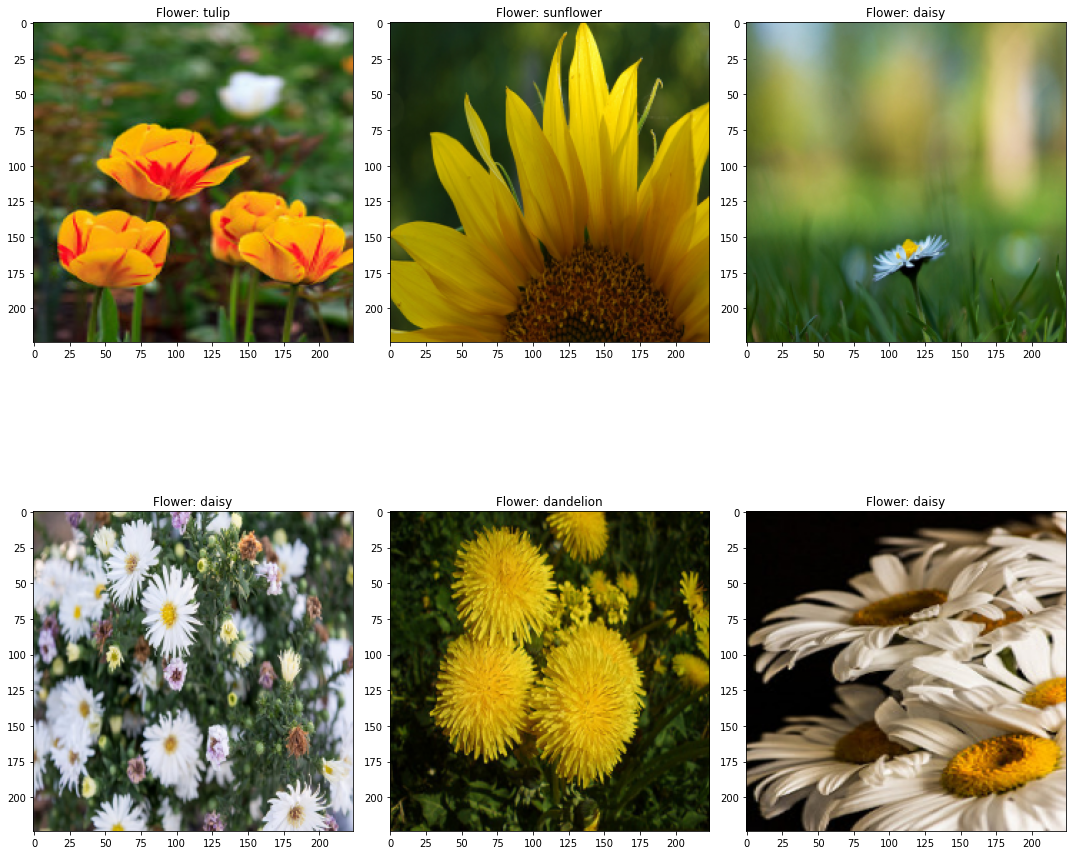

In [ ]:
fig,ax=plt.subplots(2,3)
fig.set_size_inches(15,15)
for i in range(2):
    for j in range (3):
        r = random.randint(0,len(y_string))
        ax[i,j].imshow(X[r][:, :, ::-1])
        ax[i,j].set_title('Flower: ' + y_string[r])
        
plt.tight_layout()

#### Separando em treino e validação

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# aplicando data augmentation

datagen = ImageDataGenerator(zoom_range = 0.1, 
        rotation_range= 15, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True)

datagen.fit(X_train)

#### CNN do zero

In [ ]:
inp = Input((224,224,3))
conv1 = Conv2D(64, (5,5), padding='valid', activation='relu')(inp)
conv1 = MaxPooling2D(pool_size=(2,2))(conv1)
conv1 = BatchNormalization()(conv1)
conv2 = Conv2D(96, (4,4), padding='valid', activation= 'relu')(conv1)
conv2 = MaxPooling2D(pool_size=(2,2))(conv2)
conv2 = BatchNormalization()(conv2)
conv3 = Conv2D(128, (3,3), padding='valid', activation= 'relu')(conv2)
conv3 = MaxPooling2D(pool_size=(2,2))(conv3)
conv3 = BatchNormalization()(conv3)
conv4 = Conv2D(256, (3,3), padding='valid', activation= 'relu')(conv3)
conv4 = MaxPooling2D(pool_size=(2,2))(conv4)
conv4 = BatchNormalization()(conv4)
flat = Flatten()(conv4)
dense1 = Dense(512, activation= 'relu')(flat)
dense1 = Dropout(0.5)(dense1)
dense2 = Dense(64, activation= 'relu')(dense1)
dense2 = Dropout(0.1)(dense2)
out = Dense(5, activation = 'softmax')(dense2)
model = Model(inp, out)

model.compile(optimizer=Nadam(lr = 0.0001) , loss='categorical_crossentropy', metrics=['accuracy'])

#### Treino

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=50, initial_epoch=0, validation_data = (X_val, y_val))

In [ ]:
plt.style.use('ggplot')
def plot(history):
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].set_xlabel('Epochs', fontsize=12)
    ax[1].set_xlabel('Epochs', fontsize=12)
    ax[0].legend()
    ax[1].legend()

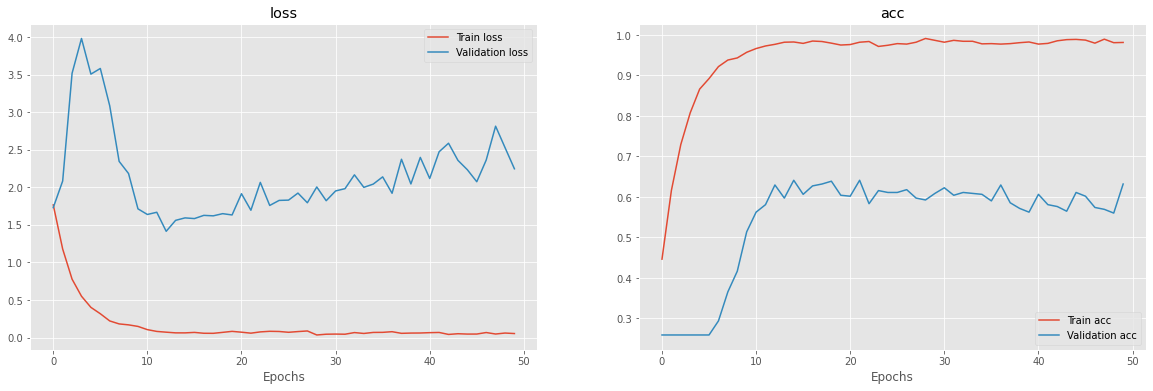

In [ ]:
plot(history)

### Transfer Learning

In [ ]:
vgg = tf.keras.applications.VGG16(input_shape=(224,224,3), 
                                  include_top=False, 
                                  weights= 'imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
x = vgg.output
x = Flatten()(x)
x = Dense(3078,activation='relu')(x) 
x = Dropout(0.5)(x)
x = Dense(256,activation='relu')(x) 
x = Dropout(0.2)(x)
out = Dense(5,activation='softmax')(x)

tf_model=Model(inputs=vgg.input,outputs=out)

for layer in tf_model.layers[:20]:
    layer.trainable=False

In [ ]:
tf_model.compile(optimizer = Nadam(0.0001) , loss = 'categorical_crossentropy', metrics=["accuracy"])

In [ ]:
history = tf_model.fit(X_train, y_train, batch_size = 1, epochs = 30, initial_epoch = 0, validation_data = (X_val, y_val))

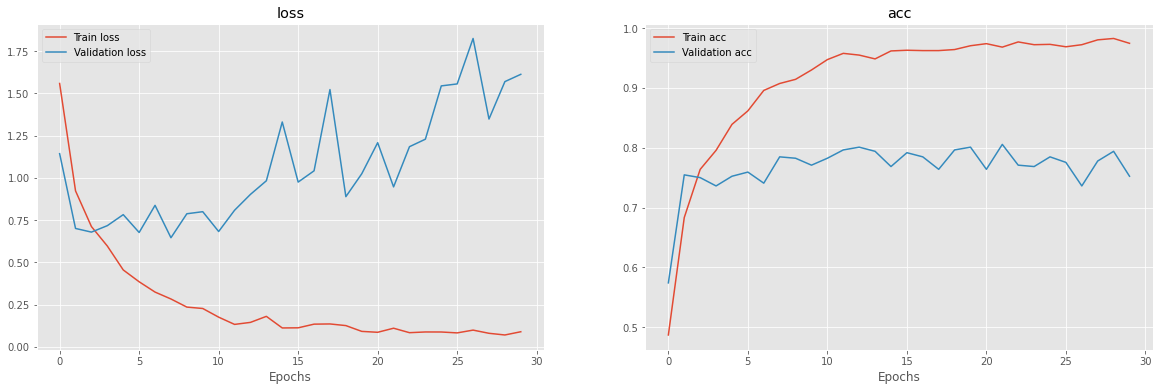

In [ ]:
plot(history)

### Classificando alguns exemplos

In [ ]:
pred = tf_model.predict(X_val)
pred = np.argmax(pred, axis = 1)

In [ ]:
pred = pd.DataFrame(pred).replace({0:'daisy',1:'dandelion',2:'rose',3:'sunflower',4:'tulip'})

y_val_string = np.argmax(y_val, axis = 1)
y_val_string = pd.DataFrame(y_val_string).replace({0:'daisy',1:'dandelion',2:'rose',3:'sunflower',4:'tulip'})

In [ ]:
mis_class = []
for i in range(len(y_val_string)):
    if(not y_val_string[0][i] == pred[0][i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

#### Visualização

Vericando alguns erros da predição

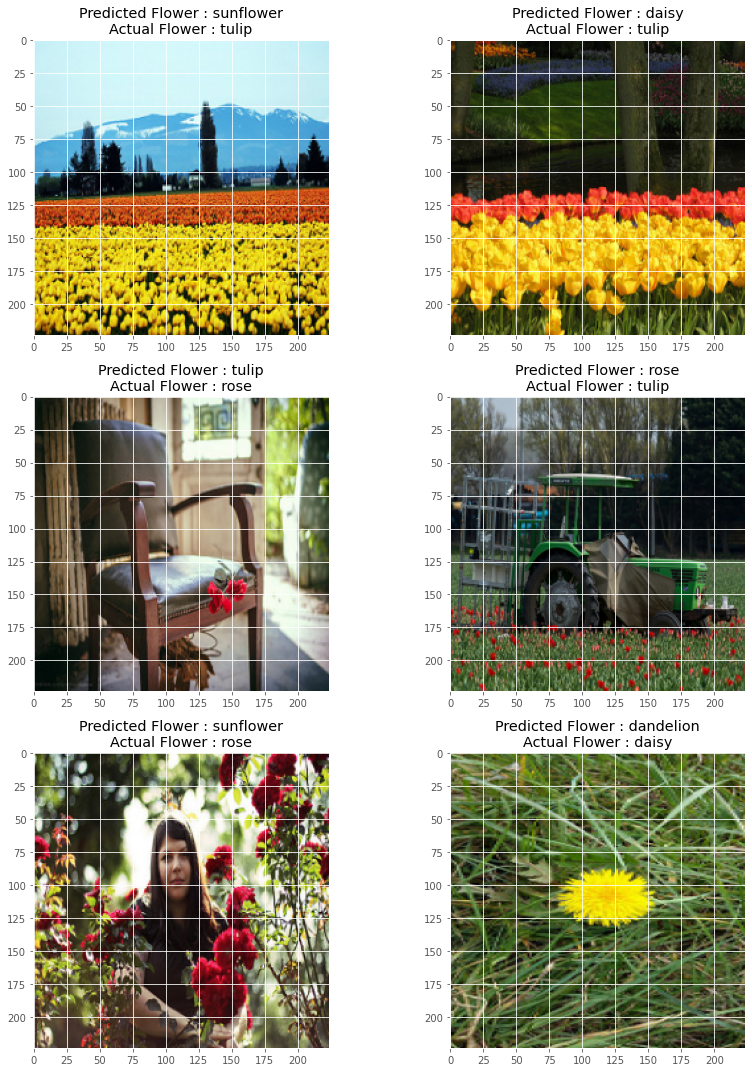

In [ ]:
count = 0
fig,ax = plt.subplots(3,2)
fig.set_size_inches(15,15)
for i in range (3):
    for j in range (2):
        ax[i,j].imshow(X_val[mis_class[count]][:,:,::-1])
        ax[i,j].set_title("Predicted Flower : "+str(pred[0][mis_class[count]])+"\n"+"Actual Flower : " + str(y_val_string[0][mis_class[count]]))
        plt.tight_layout()
        count+=1